In [11]:
# (1)

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np
import qiskit_aer.noise as noise
import matplotlib.pyplot as plt

(2) Derivation of the logical zero state

Consider the parity check matrix corresponding to the Quantum Hamming Code [[15,7,3]], $$H_X = H_Z = H = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 0 & 0 & 1 & 1 & 0 & 0 & 1 & 1 & 0 & 0 & 1 & 1 \\
1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1
\end{pmatrix}$$

Recall that in a parity check matrix, the columns are indexed by the set of qubits, $\{q_i\}_{i=1}^{15}$ and the rows are indexed by $X$ or $Z$ stabilizers, $\{X_i\}_{i=1}^4$ and $\{Z_i\}_{i=1}^4$. Additionally, the columns are the syndrome measurements. That is, 

$$\begin{array}{ccccc}
\begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix} \mapsto s_0 &
\begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix} \mapsto s_1 &
\begin{pmatrix} 0 \\ 0 \\ 1 \\ 1 \end{pmatrix} \mapsto s_2 &
\begin{pmatrix} 0 \\ 1 \\ 0 \\ 0 \end{pmatrix} \mapsto s_3 &
\begin{pmatrix} 0 \\ 1 \\ 0 \\ 1 \end{pmatrix} \mapsto s_4 \\[1em]
\begin{pmatrix} 0 \\ 1 \\ 1 \\ 0 \end{pmatrix} \mapsto s_5 &
\begin{pmatrix} 0 \\ 1 \\ 1 \\ 1 \end{pmatrix} \mapsto s_6 &
\begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix} \mapsto s_7 &
\begin{pmatrix} 1 \\ 0 \\ 0 \\ 1 \end{pmatrix} \mapsto s_8 &
\begin{pmatrix} 1 \\ 0 \\ 1 \\ 0 \end{pmatrix} \mapsto s_9 \\[1em]
\begin{pmatrix} 1 \\ 0 \\ 1 \\ 1 \end{pmatrix} \mapsto s_{10} &
\begin{pmatrix} 1 \\ 1 \\ 0 \\ 0 \end{pmatrix} \mapsto s_{11} &
\begin{pmatrix} 1 \\ 1 \\ 0 \\ 1 \end{pmatrix} \mapsto s_{12} &
\begin{pmatrix} 1 \\ 1 \\ 1 \\ 0 \end{pmatrix} \mapsto s_{13} &
\begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \end{pmatrix} \mapsto s_{14}
\end{array}$$





To find the components of the logical zero state, we first find the simultaneous +1 eigenspace of the parity check matrix. 
This satisifies $$S_i |x \rangle = (-1)^{H_i x} |x \rangle \quad \text{Nielson-Chuang 10.4.2}$$

So finding the null space of $Hx = 0$ is sufficient.

We can easily compute the RREF by permutations of the columns, as long as we track the permutations on both the qubits and its stabilizer for correcting errors. 

First, we permute the 1st and 4th rows, and the 2nd and 3rd rows. Then, we permute columns 3 and 4, and then columns 4 and 8. $$\implies \sigma_R = (23)(14),\implies \sigma_R(X_i) = X_{\sigma_R(i)}$$
 $$\implies \sigma_C = (48)(34) = (384)$$ $$\implies \sigma_C (q_i) = q_{\sigma_C(i)}$$

Since the pivot qubits single out stabilizer generators, we only have to worry about the permutation relabling
$$\sigma = (38) \implies \sigma_C (q_i) = q_{\sigma_C(i)}$$


So our RREF matrix is

$$H_{\text{RREF}} = \begin{bmatrix}
1 & 0 & 0 & 0 & 1 & 0 & 1 & 1 & 1 & 0 & 1 & 0 & 1 & 0 & 1 \\
0 & 1 & 0 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 0 & 0 & 1 & 1 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1
\end{bmatrix}$$

To get our logical zero states, we solve $H_{RREF} x = 0$ and obtain our free variables. To stay in our null space, there must an even number of 1s in first four entries of our solution vector, and an even number of 1s in the last 11 entries.

In [1]:
# (2) 

# [[15,7,3]] Parity matrix
H = [[0,0,0,0,0,0,0,1,1,1,1,1,1,1,1], [0,0,0,1,1,1,1,0,0,0,0,1,1,1,1], [0,1,1,0,0,1,1,0,0,1,1,0,0,1,1], [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]]

# RREF parity matrix
H_rref = [[1,0,0,0,1,0,1,1,1,0,1,0,1,0,1],[0,1,0,0,0,1,1,1,0,1,1,0,0,1,1],[0,0,1,0,0,0,0,0,1,1,1,1,1,1,1],[0,0,0,1,1,1,1,0,0,0,0,1,1,1,1]]

logical_zero_components = ['000000000000000','111111110000000',  '111100001111000',  '000011111111000',  '110000110011110',  '110011001100110',
                            '001111000011110', '011010011001011','101001010101101', '101010101010101', '010101011010101', '001100111100110', 
                           '100110010110011', '100101101001011','010110100101101', '011001100110011']

In [13]:
# (3)

def random_pauli_error(p):
    """
    With probability p, a uniformly random pauli is applied to a single qubit.
    
    Input: 
        0 <= p <= 1
    
    Output: 
        Quantum Circuit with 1 qubit
    """
    qc = QuantumCircuit(1)
    randnum = np.random.rand()

    if randnum < p:
        # Choose one of X, Y, Z uniformly
        pauli = np.random.choice(['X','Y','Z'])
        if pauli == 'X':
            qc.x(0)
        elif pauli == 'Y':
            qc.y(0)
        elif pauli == 'Z':
            qc.z(0)
    return qc

In [14]:
# (4)

def extract_Xsyndromes(qc, H, data_qubits, X_Check_Qubits):
    """
    Extracts X syndromes by applying CX gates from data_qubits to X_Check_Qubits based on the parity check matrix H.

    Parameters:
    - qc: QuantumCircuit to apply gates to
    - H: Parity check matrix (rows = number of syndromes, columns = data qubits)
    - data_qubits: QuantumRegister for data qubits
    - X_Check_Qubits: QuantumRegister for extracting each X syndrome
    """

    # Loop through each row of the parity check matrix
    for syndrome_index in range(len(X_Check_Qubits)):
        row = H[syndrome_index]

        # Loop through each column (data qubit) in this row
        for qubit in range(len(row)):
            element = row[qubit]

            # If the parity check matrix has a 1 in this position,
            # apply a CNOT from the data qubit to the ancilla qubit
            if element == 1:
                data_qubit = data_qubits[qubit]
                X_Check_Qubit = X_Check_Qubits[syndrome_index]
                qc.cx(data_qubit, X_Check_Qubit)

### Example usage

#data_qubits = QuantumRegister(15, name="QHC")
#X_Check_Qubits = AncillaRegister(4, name= "X_Check")
#qc = QuantumCircuit(data_qubits, X_Check_Qubits)
#extract_Xsyndromes(qc, H, data_qubits, X_Check_Qubits)
#qc.draw("mpl")

In [15]:
# (5)

def extract_Zsyndrome(qc, H, data_qubits, Z_Check_Qubits):
    """
    Extracts Z syndromes by applying CX gates from data_qubits to Z_Check_Qubits based on the parity check matrix H.

    Parameters:
        - qc: QuantumCircuit to apply gates to
        - H: Parity check matrix (rows = number of syndromes, columns = data qubits)
        - data_qubits: QuantumRegister for data qubits
        - Z_Check_Qubits: QuantumRegister for extracting each Z syndrome
    """

    # Prepare ancillas in |+> state
    for qubit in range(len(Z_Check_Qubits)):
        qc.h(Z_Check_Qubits[qubit])

    # Loop through each syndrome (row of H_matrix)
    for syndrome_index in range(len(H)):
        row = H[syndrome_index]

        # Loop through each data qubit (column in row)
        for qubit in range(len(data_qubits)):
            element = row[qubit]

            # If there is a 1 in this position, apply CNOT with ancilla as control and data qubit as target
            if element == 1:
                Z_Check_Qubit = Z_Check_Qubits[syndrome_index]
                data_qubit = data_qubits[qubit]

                qc.cx(Z_Check_Qubit, data_qubit)

    # Apply Hadamard gates to all ancillas to complete the Z-syndrome measurement
    for qubit in range(len(Z_Check_Qubits)):
        qc.h(Z_Check_Qubits[qubit])

### Example usage

#data_qubits = QuantumRegister(15, name="QHC")
#Z_Check_Qubits = AncillaRegister(4, name= "Z_Check")
#qc = QuantumCircuit(data_qubits, Z_Check_Qubits)
#extract_Zsyndrome(qc, H, data_qubits, Z_Check_Qubits)
#qc.draw("mpl")

In [16]:
# (6)

def Quantum_Hamming_Circuit(p):
    """
    This function prepares the logical zero state of the [[15,7,3]] Hamming Code, applys an error with probability p to each qubit, and corrects the error.
    
    Input: 
        p = probability of pauli error for 1 qubit
        
        (1) Prepare logical zero state
        (2) Apply random pauli to each qubit with probability p
        (3) Extract X,Z syndromes
        (4) Measure X,Z syndromes
        (5) Apply error correction
        (6) Measure data qubits

    Output: 
        Error corrected quantum circuit 

    Requires: 
        (1), (2), (3), (4), (5)
    """

    data_qubits = QuantumRegister(size = 15, name = "QHC")
    Hamming_circuit = QuantumCircuit(data_qubits)

    # (1)
    # Prepare logical zero state baased on H_rref
    for i in range(4):
        Hamming_circuit.h(data_qubits[i])
        for j in range(4,15):
            if (H_rref[i])[j] == 1:
                Hamming_circuit.cx(data_qubits[i], data_qubits[j])

    # swap qubits reflecting the swapped columns
    Hamming_circuit.swap(data_qubits[2], data_qubits[7])

    # (2)
    # Apply Pauli errors on each data qubit
    for i in range(15):
        Hamming_circuit.compose(random_pauli_error(p),inplace=True, qubits = data_qubits[i])
    
    # (3)
    # extract X-syndromes and Z-syndromes
    X_Check_Qubits = AncillaRegister(size = 4, name = "X_checks")
    Z_Check_Qubits = AncillaRegister(size = 4, name = "Z_checks")
    Hamming_circuit.add_register(X_Check_Qubits)
    Hamming_circuit.add_register(Z_Check_Qubits)

    extract_Xsyndromes(Hamming_circuit, H, data_qubits, X_Check_Qubits)
    extract_Zsyndrome(Hamming_circuit, H, data_qubits, Z_Check_Qubits)

    # (4) 
    # measure syndromes
    X_syndromes = ClassicalRegister(size = 4, name = "S_x")
    Z_syndromes = ClassicalRegister(size = 4, name = "S_z")
    
    Hamming_circuit.add_register(X_syndromes)
    Hamming_circuit.add_register(Z_syndromes)
    
    Hamming_circuit.measure(X_Check_Qubits, X_syndromes)
    Hamming_circuit.measure(Z_Check_Qubits, Z_syndromes)

    # (5)
    # corrects X-errors indexed by X-syndromes
    for i in range(15):
        with Hamming_circuit.if_test((X_syndromes,i+1)):
            Hamming_circuit.x(data_qubits[i])
    
    # corrects Z-errors indexed by Z-syndromes
    for i in range(15):
        with Hamming_circuit.if_test((Z_syndromes,i+1)):
            Hamming_circuit.z(data_qubits[i])

    # (6)
    # measures the output
    qubit_measurements = ClassicalRegister(15, name=f"cl")
    Hamming_circuit.add_register(qubit_measurements)
    Hamming_circuit.measure(data_qubits, qubit_measurements)

    return Hamming_circuit

### Example usage
    
#p = .2
#qc = Quantum_Hamming_Circuit(p)
#qc.draw("mpl")

(0, 1.0)
(0.04, 0.8)
(0.08, 0.45)
(0.12, 0.5)
(0.16, 0.25)


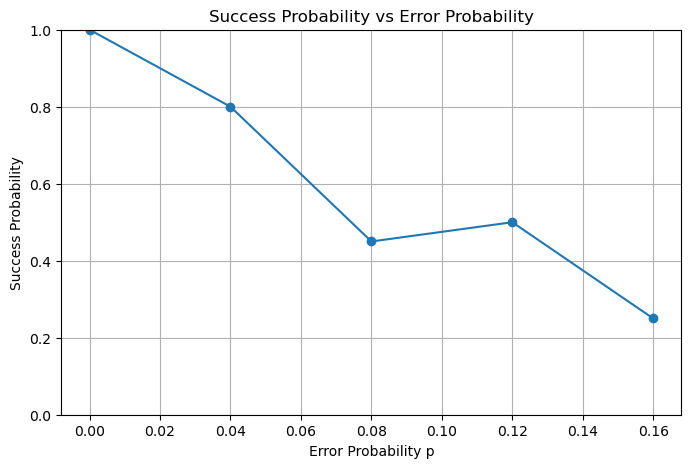

In [33]:
# (7)
def success_probabilities(p_values, logical_zero_components):
    """
    Calculates the success probabilities for various values of p. Each success proability is determined by total_trials = "20".
    
    The success probability is the probability that you measure a component of the logical zero state after applying the Quantum_Hamming_Circuit

    Input: 
        p_values = Array of probabilities
        logical_zero_components = Components of the logical zero state

    Output:
        Array of success probabilities for each probability in p_values
        
    """
    
    success_prob = []

    for p in p_values:
        simulator = AerSimulator()
    
        success = 0
        total_trials = 20
    
        for i in range(total_trials):
            trials = 1
            compiled_circuit = transpile(Quantum_Hamming_Circuit(p), simulator)
            job = simulator.run(compiled_circuit, shots = trials)
            counts = job.result().get_counts()
            for key in counts:
                if key[:15] in logical_zero_components:
                    success += counts[key]

        success_prob.append(success/total_trials)
        print(f"({p}, {success/total_trials})")

    return success_prob

### Example usage    
### Run simulation

# (x, y, z) Create z points uniformly in [x,y]
p_values = [0, 0.04, 0.08, 0.12, 0.16]

success_probs = success_probabilities(p_values, logical_zero_components)

# Plotting
plt.figure(figsize=(8,5))
plt.plot(p_values, success_probs, marker='o')
plt.xlabel('Error Probability p')
plt.ylabel('Success Probability')
plt.title('Success Probability vs Error Probability')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


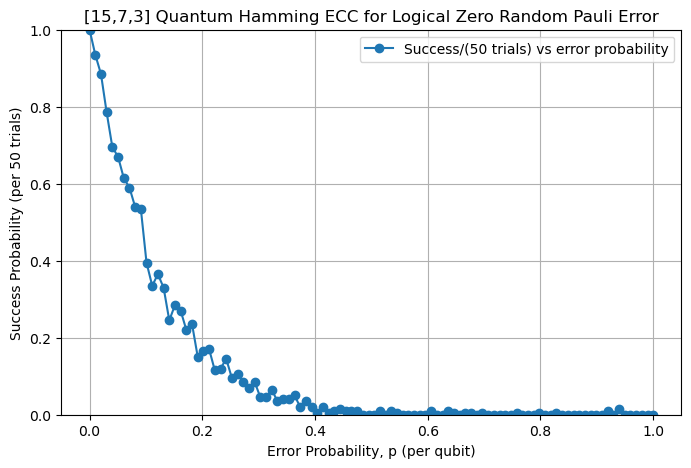

In [26]:
# (7)

# def success_probabilities(p_values, logical_zero_components):
#     """
#     Calculates the success probabilities for various values of p. Each success proability is determined by total_trials = 100.
    
#     The success probability is the probability that you measure a component of the logical zero state after applying the Quantum_Hamming_Circuit

#     Input: 
#         p_values = Array of probabilities
#         logical_zero_components = Components of the logical zero state

#     Output:
#         Array of success probabilities for each probability in p_values
        
#     """
    
#     success_prob = []
#     j=0
#     for p in p_values:
#         simulator = AerSimulator()
    
#         success = 0
#         total_trials = 200
    
#         for i in range(total_trials):
#             trials = 1
#             compiled_circuit = transpile(Quantum_Hamming_Circuit(p), simulator)
#             job = simulator.run(compiled_circuit, shots = trials)
#             counts = job.result().get_counts()
#             for key in counts:
#                 if key[:15] in logical_zero_components:
#                     success += counts[key]

#         j += 1
#         print(j)
#         success_prob.append(success/total_trials)
#         #print(f"{p}, {success_prob}")

#     return success_prob

# ### Example usage    
# # Run simulation
# # (x, y, z) Create z points uniformly in [x,y]
# #p_values = [0, 0.2, 0.4, 0.6. 0.8, 1.0, 1.2, 1.4]
# p_values = np.linspace(0, 1, 100)

# success_probs = success_probabilities(p_values, logical_zero_components)

# # Plotting
# plt.figure(figsize=(8,5))
# plt.plot(p_values, success_probs, marker='o', label='Success/(50 trials) vs error probability')
# plt.xlabel('Error Probability, p (per qubit)')
# plt.ylabel('Success Probability (per 200 trials)')
# plt.title('[15,7,3] Quantum Hamming ECC for Logical Zero Random Pauli Error')
# plt.grid(True)
# plt.ylim(0, 1)
# plt.legend()  # Add the legend
# plt.show()